#Chapter 7: Telling Birds from Airplanes: Learning from Images

*    Working through an image recognition problem, step by step
*    Building a feed forward neural network to classify images
*    Loading data using Datasets and DataLoaders
*    Why and how to use a classification loss
*    Describing how convolution works
*    Building a convolutional neural network to classify images

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
from torchvision import datasets
data_path="/content"
#CIFAR10 is dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class
train=datasets.CIFAR10(root=data_path,train=True,download=True)
test=datasets.CIFAR10(root=data_path,train=False,download=True)

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [3]:
print(len(train))
print(len(test))

50000
10000


In [4]:
class_names=train.classes #Class labels
img,label=train[99]
img,label,class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FE8B7DBDF98>,
 1,
 'automobile')

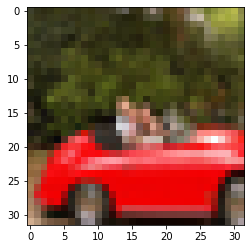

In [5]:
plt.imshow(img)
plt.show()

In [6]:
from torchvision import transforms
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [7]:
from torchvision import transforms
to_tensor=transforms.ToTensor()
img_tensor=to_tensor(img)
img_tensor.shape #3(RGB),32(width),32(height)

torch.Size([3, 32, 32])

In [8]:
img_tensor

tensor([[[0.2431, 0.1961,  ..., 0.7176, 0.5373],
         [0.2471, 0.2157,  ..., 0.6706, 0.5686],
         ...,
         [0.7176, 0.5882,  ..., 0.5294, 0.5608],
         [0.8196, 0.7137,  ..., 0.5098, 0.6627]],

        [[0.2510, 0.1961,  ..., 0.7216, 0.5333],
         [0.2549, 0.2078,  ..., 0.6824, 0.5725],
         ...,
         [0.5725, 0.4627,  ..., 0.4627, 0.4902],
         [0.6824, 0.5922,  ..., 0.4667, 0.6118]],

        [[0.1725, 0.1020,  ..., 0.2980, 0.2824],
         [0.1451, 0.1020,  ..., 0.2941, 0.3020],
         ...,
         [0.4588, 0.3725,  ..., 0.3843, 0.4314],
         [0.5647, 0.4824,  ..., 0.4353, 0.6275]]])

In [9]:
#Importing image directly
train_tensor=datasets.CIFAR10(data_path,train=True,download=False,transform=transforms.ToTensor())
test_tensor=datasets.CIFAR10(data_path,train=False,download=False,transform=transforms.ToTensor())

In [10]:
img_t,_=train_tensor[99]
print(type(img_t))
print(img_t.shape,img_t.dtype)
print(img_t)

<class 'torch.Tensor'>
torch.Size([3, 32, 32]) torch.float32
tensor([[[0.2431, 0.1961,  ..., 0.7176, 0.5373],
         [0.2471, 0.2157,  ..., 0.6706, 0.5686],
         ...,
         [0.7176, 0.5882,  ..., 0.5294, 0.5608],
         [0.8196, 0.7137,  ..., 0.5098, 0.6627]],

        [[0.2510, 0.1961,  ..., 0.7216, 0.5333],
         [0.2549, 0.2078,  ..., 0.6824, 0.5725],
         ...,
         [0.5725, 0.4627,  ..., 0.4627, 0.4902],
         [0.6824, 0.5922,  ..., 0.4667, 0.6118]],

        [[0.1725, 0.1020,  ..., 0.2980, 0.2824],
         [0.1451, 0.1020,  ..., 0.2941, 0.3020],
         ...,
         [0.4588, 0.3725,  ..., 0.3843, 0.4314],
         [0.5647, 0.4824,  ..., 0.4353, 0.6275]]])


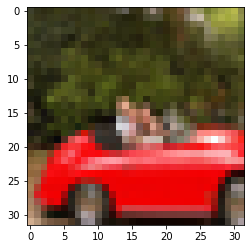

In [11]:
#plt.imshow(img_t) has to be permuted so the data will be (Width, Height, Channels)
plt.imshow(img_t.permute(1,2,0))

In [12]:
#Stacking tensors
#50,000x (Channels, Width, Height) - 3 dimensions
imgs=torch.stack([img_t for img_t, _ in train_tensor],dim=3) #List.append in Python; dim=dimension (direction of stacking the data)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [13]:
imgs.view(3,-1) #View --> Reshaping

tensor([[0.2314, 0.6039,  ..., 0.7647, 0.6392],
        [0.2431, 0.6941,  ..., 0.7451, 0.6392],
        [0.2471, 0.7333,  ..., 0.6706, 0.6314]])

In [14]:
imgs.view(3,-1).mean(dim=1) #Collapse the dimension 1 --> column

tensor([0.4915, 0.4823, 0.4468])

In [15]:
mean=imgs.view(3,-1).mean(dim=1)
std=imgs.view(3,-1).std(dim=1)

In [16]:
mean

tensor([0.4915, 0.4823, 0.4468])

In [17]:
std

tensor([0.2470, 0.2435, 0.2616])

In [18]:
#We need to normalize the mean and standard deviation to have 0 mean and std 1 for each column
#The gradient descent will work faster by this calculation (normalization)
transforms.Normalize(mean,std)

Normalize(mean=tensor([0.4915, 0.4823, 0.4468]), std=tensor([0.2470, 0.2435, 0.2616]))

In [19]:
transformer=transforms.Compose([
                                transforms.ToTensor(),          #Convert to Tensor
                                transforms.Normalize(mean,std)  #Tensor to normalized tensor
])

transformed_train=datasets.CIFAR10(data_path,train=True,download=False,transform=transformer)
transformed_test=datasets.CIFAR10(data_path,train=False,download=False,transform=transformer)

### Distinguishing Birds from Airplane

In [20]:
#Making simple sequential neural network that can distingusih bird from airplane image
#Extract the data that contain the 'airplane' and 'bird'
label_map={0:0,2:1}
class_names={'airplane','bird'}
train2=[(img,label_map[label]) for img,label in transformed_train if label in [0,2]]
test2=[(img,label_map[label]) for img,label in transformed_test if label in [0,2]]

In [21]:
import torch.nn as nn
n_out=2

#Sequential Neural Network here:
model=nn.Sequential( 
      nn.Linear(3072,512), #3*32*32=3072 (Total dimension of each pixel in the data) and narrow it down to 512
      nn.Tanh(), #First layer used hyperbolic tangent as ACTIVATION FUNCTION
      nn.Linear(512,n_out), #Start 512 dimension, and set the number as n_out=2 for distinguish only for 2 categories (airplane and bird)
)

In [22]:
img,_=transformed_train[0]
#We use unsqueeze when we want to pass the single dataset into the PyTorch model
img_batch=img.view(-1).unsqueeze(0)
img_batch

tensor([[-1.0529, -1.3069,  ..., -0.4487, -0.6286]])

In [23]:
model(img_batch)

tensor([[0.1104, 0.1697]], grad_fn=<AddmmBackward>)

In [24]:
#Softmax Layer
#The softmax layer makes the probability whether the data belongs to category a or b
import torch.nn as nn
softmax=nn.Softmax(dim=1) #Applying Softmax Function crossing dim=1
#We use the dimension 1 because we want to apply the softmax function by crossing along with the column which is the same with the mean
x=torch.randn(1,2)
print(x)
softmax(x)

tensor([[-0.5623, -2.2761]])


tensor([[0.8473, 0.1527]])

In [25]:
n_out=2
#The Model
model=nn.Sequential(
      nn.Linear(3072,512),
      nn.Tanh(),
      nn.Linear(512,n_out),
      nn.LogSoftmax(dim=1) #The final output layer
      #We added LogSoftmax in order to produce the probability value
      #The probability will be explained in the form of log value
)

model(img_batch)

tensor([[-0.6734, -0.7133]], grad_fn=<LogSoftmaxBackward>)

In [26]:
import torch
import torch
#Batch Learning
#Epoch 1, ..., 50000
#Batch 1~64 --> 65~128, so on. Update the model for each batch
#We usually shuffle the data for each epoch
#So, we may have different batch data for each epoch
#Enhance the effectiveness of the parameter learning

train_loader=torch.utils.data.DataLoader(train2,batch_size=64,shuffle=True)
#Train loader is made by the torch.utils.data.DataLoader

##CODE IN THE TEXTBOOK##
#model=nn.Sequantial(
#      nn.Linear(3072,512),
#      nn.Tanh(),
#      nn.Linear(512,2),
#      nn.LogSoftmax(dim=1)
#)

#Neural Network Architecture
model=nn.Sequential(
      nn.Linear(3072,1024),
      nn.Tanh(),
      nn.Linear(1024,512),
      nn.Tanh(),
      nn.Linear(512,128),
      nn.Tanh(),
      nn.Linear(128,2),
      nn.LogSoftmax(dim=1)
)

learning_rate=1e-2

optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

loss_fn=nn.NLLLoss() #Used with LogSoftmax Function --> LOSS FUNCTION for Classification Problem

n_epochs=100 #Iterate through the entire dataset for 100 times

for epoch in range(n_epochs):
  for imgs,labels in train_loader: #For each iteration, 64 random pictures will be passed through the NN
    batch_size=imgs.shape[0]
    outputs=model(imgs.view(batch_size,-1))
    loss=loss_fn(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  print("Epoch: %d, Loss: %f" % (epoch,float(loss)))

Epoch: 0, Loss: 0.682629
Epoch: 1, Loss: 0.520883
Epoch: 2, Loss: 0.772743
Epoch: 3, Loss: 0.196593
Epoch: 4, Loss: 0.423501
Epoch: 5, Loss: 0.213678
Epoch: 6, Loss: 0.241123
Epoch: 7, Loss: 0.246200
Epoch: 8, Loss: 0.567128
Epoch: 9, Loss: 0.235563
Epoch: 10, Loss: 0.451099
Epoch: 11, Loss: 0.591853
Epoch: 12, Loss: 0.422638
Epoch: 13, Loss: 0.112566
Epoch: 14, Loss: 0.457651
Epoch: 15, Loss: 0.360295
Epoch: 16, Loss: 0.209417
Epoch: 17, Loss: 0.398772
Epoch: 18, Loss: 0.189395
Epoch: 19, Loss: 0.344837
Epoch: 20, Loss: 0.333649
Epoch: 21, Loss: 0.230753
Epoch: 22, Loss: 0.309544
Epoch: 23, Loss: 0.176528
Epoch: 24, Loss: 0.207340
Epoch: 25, Loss: 0.437659
Epoch: 26, Loss: 0.229373
Epoch: 27, Loss: 0.093630
Epoch: 28, Loss: 0.114195
Epoch: 29, Loss: 0.149567
Epoch: 30, Loss: 0.172021
Epoch: 31, Loss: 0.086830
Epoch: 32, Loss: 0.146596
Epoch: 33, Loss: 0.141408
Epoch: 34, Loss: 0.101629
Epoch: 35, Loss: 0.066884
Epoch: 36, Loss: 0.083779
Epoch: 37, Loss: 0.089732
Epoch: 38, Loss: 0.100

In [27]:
val_loader=torch.utils.data.DataLoader(test2,batch_size=64,shuffle=False)

correct=0
total=0

with torch.no_grad():
  for imgs,labels in val_loader:
    batch_size=imgs.shape[0]
    outputs=model(imgs.view(batch_size,-1)) #This will generate the probability
    _,predicted=torch.max(outputs,dim=1) #We pick the category that has maximum probability
    total+=labels.shape[0] #True labels
    correct+=int((predicted==labels).sum())

print("Accuracy: %f",correct/total)

Accuracy: %f 0.804
